In [2]:
from bioblend.galaxy import GalaxyInstance
import pandas as pd
from io import StringIO
import os
import requests
import pip
pip.main(["install", "openpyxl"])

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


0

# Add galaxy API key
Add `GALAXY_API_KEY` from `https://usegalaxy.eu/user/api_key` via `export GALAXY_API_KEY="<key>"` or `%env  GALAXY_API_KEY=<key>` in jupyter

In [3]:
%env GALAXY_API_KEY=

env: GALAXY_API_KEY=88c98d1c08f608ace9cbf5fd766eda96


# Biolytix Data

## Collection of AMR, VR counts

In [5]:
def get_summary_of_collection(gi, collection_name, history_id, column_name):
    """
    Collects the counts of datasets in a collection
    """

    datasets = gi.datasets.get_datasets(name = collection_name, history_id = history_id)

    #print(datasets)

    #fetch collection by name
    if len(datasets) > 1:
        print("too many datasets with that name")

    for dataset in datasets:
        if dataset['history_content_type']=='dataset_collection': #get only collections
            if dataset['job_state_summary']['all_jobs'] == dataset['job_state_summary']['ok']: #get only collections where all jobs are ok
                dataset_collection_id = dataset["id"]

    look_up = {}
    # get data of the elements in the collection
    collection = gi.dataset_collections.show_dataset_collection(dataset_collection_id = dataset_collection_id)
    for element in collection['elements']:

        element_name = element['element_identifier']
        element_id = element['object']['id']
        data = gi.datasets.download_dataset(element_id, maxwait = 3)
        df = pd.read_csv(StringIO(data.decode("utf-8")), sep="\t")

        look_up[element_name] = len(df)
        print(element_name, len(df))

    df = pd.DataFrame(look_up.items())
    df.set_index(0, inplace=True)
    df.index.name = "Name"
    df.columns = [column_name]

    return(df)    

## Get df for AMR and VF

In [6]:
gi = GalaxyInstance(url='https://usegalaxy.eu/', key=os.environ['GALAXY_API_KEY'])

collection_name = "VFs of genes Identified by VFDB"
history_id = "a90a5dd2a4c17493"
column_name = "VFs"

VF_df = get_summary_of_collection(gi, collection_name, history_id, column_name)

collection_name = "AMR Identifiied by NCBI"
history_id = "a90a5dd2a4c17493"
column_name = "AMR"

AMR_df = get_summary_of_collection(gi, collection_name, history_id, column_name)

too many datasets with that name
Spike1Barcode10 121
Spike1Barcode11 60
Spike1Barcode12 0
Spike1Barcode13 0
Spike1Barcode14 0
Spike1Barcode15 0
 Spike2Barcode10 135
Spike2Barcode11 97
Spike2Barcode12 77
Spike2Barcode13 0
Spike2Barcode14 0
Spike2Barcode15 0
Spike2bBarcode10 175
Spike2bBarcode11 97
Spike2bBarcode12 84
Spike2bBarcode13 0
Spike2bBarcode14 0
Spike2bBarcode15 0
Spike2bUnclassified 80
Spike3Barcode11 0
Spike3Barcode13 0
Spike3Barcode14 0
Spike3Barcode15 0
Spike3Unclassified 0
Spike3bBarcode10 25
Spike3bBarcode12 70
Spike3bBarcode11 79
Spike3bBarcode13 0
Spike3bBarcode14 0
Spike3bUnclassified 0
Spike3bBarcode15 0
Spike4Barcode01 69
Spike4Barcode02 0
Spike4Barcode03 0
Spike4Barcode04 0
Spike4Barcode05 0
Spike4Barcode07 0
Spike4Barcode08 0
Spike4Barcode10 0
Spike4Barcode11 0
Spike4Barcode12 0
Spike4Barcode13 0
Spike4Barcode14 0
Spike4Barcode15 0
Spike4Barcode16 0
Spike4Unclassified 0
too many datasets with that name
Spike1Barcode10 5
Spike1Barcode11 0
Spike1Barcode12 0
Spike1Bar

In [7]:
frames = [VF_df, AMR_df]
merged_df = pd.concat(frames, axis = 1)

#from IPython.core.display import HTML
print(merged_df.to_string())



                     VFs  AMR
Name                         
Spike1Barcode10      121    5
Spike1Barcode11       60    0
Spike1Barcode12        0    0
Spike1Barcode13        0    0
Spike1Barcode14        0    0
Spike1Barcode15        0    0
 Spike2Barcode10     135    6
Spike2Barcode11       97    0
Spike2Barcode12       77    0
Spike2Barcode13        0    0
Spike2Barcode14        0    0
Spike2Barcode15        0    0
Spike2bBarcode10     175    4
Spike2bBarcode11      97    0
Spike2bBarcode12      84    0
Spike2bBarcode13       0    0
Spike2bBarcode14       0    0
Spike2bBarcode15       0    0
Spike2bUnclassified   80    5
Spike3Barcode11        0    0
Spike3Barcode13        0    0
Spike3Barcode14        0    0
Spike3Barcode15        0    0
Spike3Unclassified     0    0
Spike3bBarcode10      25    0
Spike3bBarcode12      70    0
Spike3bBarcode11      79    0
Spike3bBarcode13       0    0
Spike3bBarcode14       0    0
Spike3bUnclassified    0    0
Spike3bBarcode15       0    0
Spike4Barc

## Map with metadata

In [8]:
meta_df = pd.read_excel(open('data/FoodbornePathogenDetectionDataAnalysis.xlsx', 'rb'), sheet_name='Biolytix Spiked') 
meta_df.set_index("Galaxy ID", inplace=True)
meta_df.index.name = "Name"
frames = [merged_df, meta_df]
result = pd.concat(frames, axis = 1)
# print(len(result.columns))
# print(len(meta_df.columns))

print(result.to_string())

                       VFs  AMR Sample Barcode Number DSM-Number  bx-number  Lot-Number Data Sequencing Source Sequencing Date                                                                              Information                                 Expected Strain Deplition   CT Value           CFU Enrichment   Medium  Galaxy Analysis Date  History Link                                                                                                                                                                                                                                                                                                                                                                                                           Comments
Name                                                                                                                                                                                                                                              

## plot it 

### Bar plot (Paul's example)

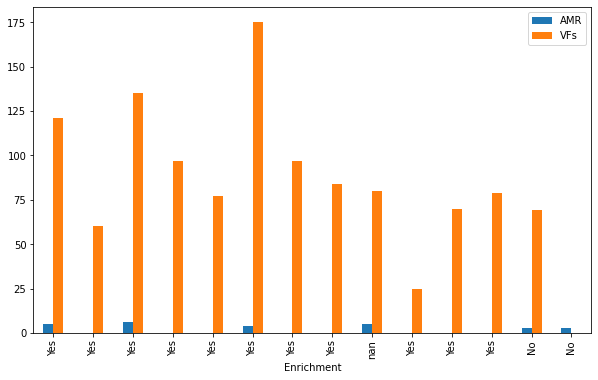

In [9]:
import matplotlib.pyplot as plt
import numpy as np

selection = result[(result["AMR"] != 0) | (result["VFs"] != 0)]
selection = selection.dropna(subset = ["AMR","VFs"])

#print(selection["Enrichment"])
#print(selection.columns)
selection.set_index(["Enrichment"], drop=True, inplace = True)
#print(selection)
selection.plot( kind = "bar",
                #x = ["Enrichment"],
                y = ["AMR","VFs"], 
                figsize=(10,6), 
                )
plt.show()

### Violin Plot

#### for VFs

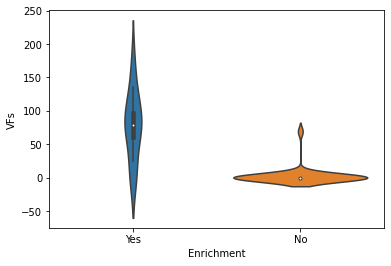

In [10]:
import numpy as np
import seaborn as sns


sns.violinplot(data=result, x="Enrichment", y="VFs")
plt.show()

#### for AMR

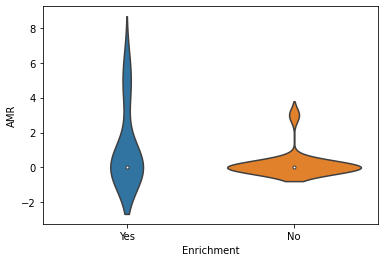

In [11]:
sns.violinplot(data=result, x="Enrichment", y="AMR")
plt.show()

### Scatter Plot

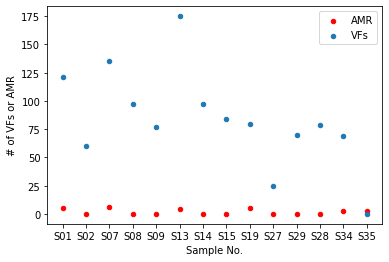

In [12]:
ax = selection.plot(kind='scatter', x='Sample', y='AMR', color='r', label="AMR")    
selection.plot.scatter(
                x = 'Sample',
                y = 'VFs',
                ax=ax, label="VFs")
ax.set_ylabel("# of VFs or AMR")
ax.set_xlabel("Sample No.")
plt.show()

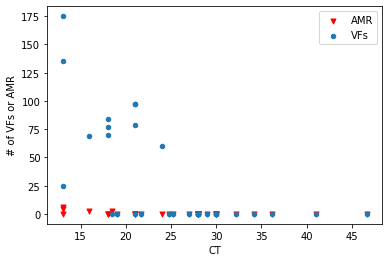

In [13]:
selection = result[(result["AMR"] >= 0) | (result["VFs"] >= 0)]
selection = selection.dropna(subset = ["AMR","VFs"])
selection.set_index(["Enrichment"], drop=True, inplace = True)

ax = selection.plot(kind='scatter', x='CT Value', y='AMR', color='r', marker='v', s=25, label="AMR")    
selection.plot.scatter(
                x = 'CT Value',
                y = 'VFs',
                ax=ax, label="VFs")
ax.set_ylabel("# of VFs or AMR")
ax.set_xlabel("CT")
plt.show()

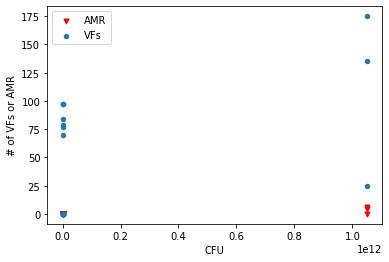

In [14]:
ax = selection.plot(kind='scatter', x='CFU', y='AMR', color='r', marker='v', s=25, label="AMR")    
selection.plot.scatter(
                x = 'CFU',
                y = 'VFs',
                ax=ax, label="VFs")
ax.set_ylabel("# of VFs or AMR")
ax.set_xlabel("CFU")
plt.show()

### Taxonomy Profiling Heatmap -- in biolytix_taxonomy_heatmap_from_collection.ipynb